In [1]:
pip install wandb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 29.5 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.9/97.9 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.2/249.2 kB 5.9 MB/s eta 0:00:00:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
import wandb

In [6]:
wandb.init(project="lunarLander(try)", entity = "rl_proj")

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


In [7]:
import gymnasium as gym
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import os

os.makedirs("outputs", exist_ok=True)

DEVICE = "cpu"
ACTION_SPACE = [0, 1, 2, 3]
EPISODES = 5000
BATCH_SIZE = 8
GAMMA = 0.99
RENDER = False

class ReinforceNetwork(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(ReinforceNetwork, self).__init__()
        self.fc1 = nn.Linear(n_inputs, 16)
        self.fc2 = nn.Linear(16, 32)
        self.fc3 = nn.Linear(32, n_outputs)

    def forward(self, x):
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, dtype=torch.float32, device=DEVICE)
        x = x.unsqueeze(0) if x.dim() == 1 else x
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        actions = torch.softmax(self.fc3(x), dim=-1)
        action = self.get_action(actions)
        log_prob_action = torch.log(actions.squeeze(0))[action]
        return action, log_prob_action

    def get_action(self, actions):
        return np.random.choice(ACTION_SPACE, p=actions.squeeze(0).detach().cpu().numpy())

env = gym.make("LunarLander-v2")
model = ReinforceNetwork(env.observation_space.shape[0], env.action_space.n).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

all_rewards = []
all_losses = []
batch_rewards = []
batch_log_probs = []
best_rolling = -99999

for episode in range(EPISODES):
    state, _ = env.reset()
    episode_rewards = []
    episode_log_probs = []

    while True:
        if RENDER:
            env.render()

        action, log_prob = model(state)
        #state, reward, done, info = env.step(action)
        step_result = env.step(action)
        state, reward, done, info = step_result[:4]

        episode_log_probs.append(log_prob)
        episode_rewards.append(reward / 100)  # Scaling reward

        if done:
            total_reward = np.sum(episode_rewards)
            all_rewards.append(total_reward)

            rolling_avg_reward = pd.Series(all_rewards).tail(100).mean()
            print(f"EPISODE {episode} SCORE: {total_reward} roll: {rolling_avg_reward}")
            torch.save(model.state_dict(), 'outputs/last_params_prueba.pth')

            if rolling_avg_reward > best_rolling:
                best_rolling = rolling_avg_reward
                print("saving...")
                torch.save(model.state_dict(), 'outputs/best_params_prueba.pth')

            batch_rewards.extend(episode_rewards)
            batch_log_probs.extend(episode_log_probs)

            if (episode + 1) % BATCH_SIZE == 0 or episode == EPISODES - 1:
                discounted_rewards = []
                Gt = 0
                for reward in reversed(batch_rewards):
                    Gt = reward + GAMMA * Gt
                    discounted_rewards.insert(0, Gt)

                discounted_rewards = torch.tensor(discounted_rewards, dtype=torch.float32, device=DEVICE)
                discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / (discounted_rewards.std() + 1e-9)
                batch_log_probs = torch.stack(batch_log_probs)

                policy_gradient = -batch_log_probs * discounted_rewards

                optimizer.zero_grad()
                loss = policy_gradient.sum()
                loss.backward()
                optimizer.step()

                all_losses.append(loss.item())
                batch_rewards = []
                batch_log_probs = []

            break

env.close()


EPISODE 0 SCORE: -0.8754374541088158 roll: -0.8754374541088158
saving...
EPISODE 1 SCORE: -2.1139988753938614 roll: -1.4947181647513386
EPISODE 2 SCORE: -2.117471669605723 roll: -1.7023026663694667
EPISODE 3 SCORE: -1.8921248543647087 roll: -1.7497582133682772
EPISODE 4 SCORE: -3.8892481332349016 roll: -2.1776561973416024
EPISODE 5 SCORE: -2.0178685948641615 roll: -2.151024930262029
EPISODE 6 SCORE: -2.2325859296675263 roll: -2.162676501605671
EPISODE 7 SCORE: -2.2295727841387647 roll: -2.1710385369223077
EPISODE 8 SCORE: -3.4177090742488057 roll: -2.3095574855141408
EPISODE 9 SCORE: -1.8185010829615535 roll: -2.260451845258882
EPISODE 10 SCORE: -2.386284038648453 roll: -2.271891135567025
EPISODE 11 SCORE: -1.3819336611000392 roll: -2.197728012694776
EPISODE 12 SCORE: -1.7791861455400584 roll: -2.1655324844521058
EPISODE 13 SCORE: -1.9055265404142387 roll: -2.146960631306544
EPISODE 14 SCORE: -1.096628629402418 roll: -2.076938497846269
EPISODE 15 SCORE: -1.1532646001186173 roll: -2.019

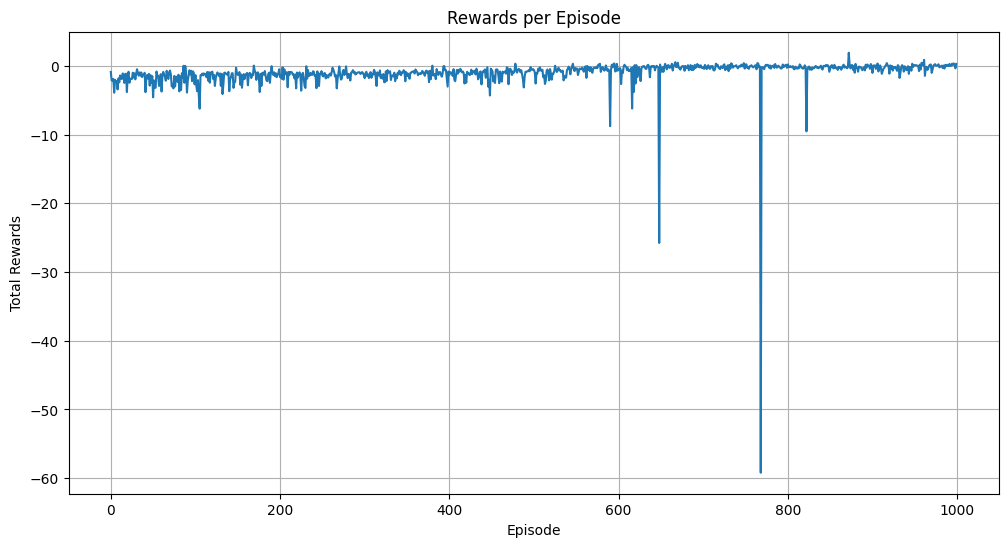

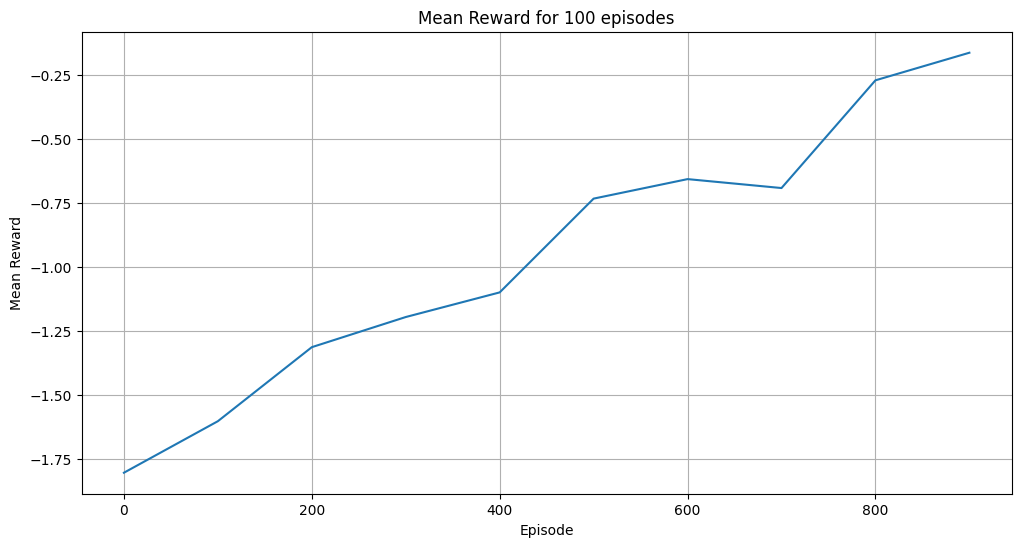

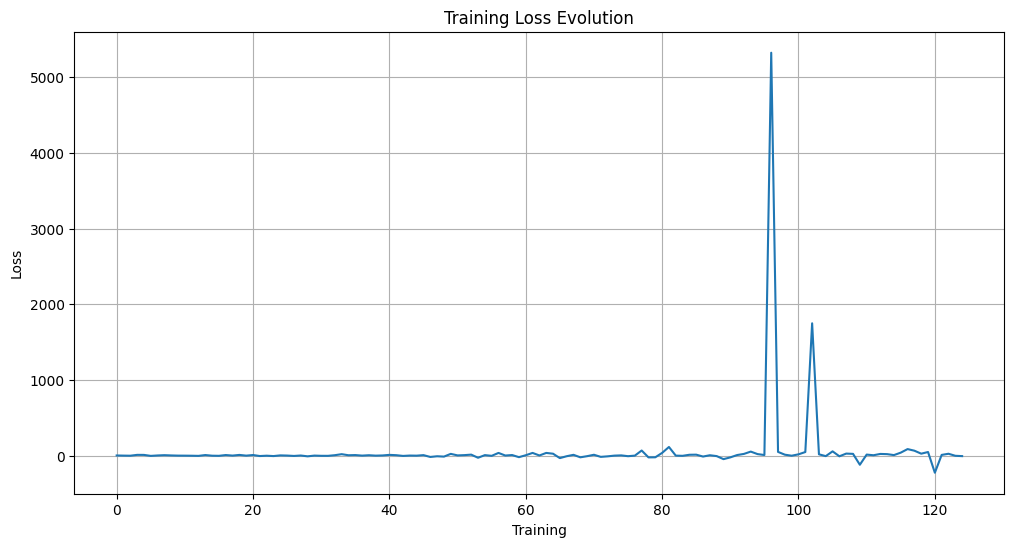

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(all_rewards)
plt.title("Rewards per Episode")
plt.xlabel("Episode")
plt.ylabel("Total Rewards")
plt.grid()

# Log the plot to wandb
wandb.log({"Rewards per Episode": wandb.Image(plt)})
plt.show()

# Graficar la evolución de las recompensas promedio cada 100 episodios
average_rewards = [pd.Series(all_rewards).iloc[i:i+100].mean() for i in range(0, len(all_rewards), 100)]
plt.figure(figsize=(12, 6))
plt.plot(range(0, len(all_rewards), 100), average_rewards)
plt.title("Mean Reward for 100 episodes")
plt.xlabel("Episode")
plt.ylabel("Mean Reward")
plt.grid()

# Log the plot to wandb
wandb.log({"Mean Reward for 100 Episodes": wandb.Image(plt)})
plt.show()

# Graficar la evolución de la pérdida a lo largo del entrenamiento
plt.figure(figsize=(12, 6))
plt.plot(all_losses)
plt.title("Training Loss Evolution")
plt.xlabel("Training")
plt.ylabel("Loss")
plt.grid()

# Log the plot to wandb
wandb.log({"Training Loss Evolution": wandb.Image(plt)})
plt.show()

wandb.finish()
